# Prepare full/intact complexes for the PDBBind dataset

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
from tqdm import tqdm
import pickle

In [3]:
from rdkit import Chem
from Bio.PDB import PDBParser, MMCIFParser
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.Polypeptide import is_aa

In [4]:
from ppi.data_utils import parse_pdb_structure, extract_coords, three_to_one_standard

In [5]:
def is_protein_chain(chain):
    # assert if a chain is protein chain
    pdb_seq = "".join(
        [
            three_to_one_standard(res.get_resname())
            for res in chain.get_residues()
            if is_aa(res)
        ]
    )
    # has >= 1 AAs in the chain
    return len(pdb_seq) > 1

In [6]:
def parse_pdbbind_complex(pdb_id, pignet_data_dir):
    '''Parse PDB file and molecule file.
    Remove non-protein chains 
    '''
    # load the protein from pdb file:
    pdb_path = os.path.join(DATA_DIR, f'refined-set/{pdb_id}/{pdb_id}_protein.pdb')

    pdb_parser = PDBParser(PERMISSIVE=True, QUIET=True)
    protein_structure = parse_pdb_structure(pdb_parser, pdb_id, pdb_path)    
    chains_to_remove = []
    for chain in protein_structure.get_chains():    
        if not is_protein_chain(chain):
            chains_to_remove.append(chain.id)

    # remove non-protein chains        
    for chain_id in chains_to_remove:
        protein_structure[0].detach_child(chain.id)
    
#     # load ligand from mol2
#     mol2_file = os.path.join(DATA_DIR, f'refined-set/{pdb_id}/{pdb_id}_ligand.mol2')
#     ligand = Chem.MolFromMol2File(mol2_file)
#     if ligand is None:
#         # load ligand from sdf
#         sdf_file = os.path.join(DATA_DIR, f'refined-set/{pdb_id}/{pdb_id}_ligand.sdf')
#         ligand = Chem.SDMolSupplier(sdf_file)[0]
    
#     assert ligand is not None
    # load ligand from PIGNet processed data
    with open(os.path.join(pignet_data_dir, "data", pdb_id), "rb") as f:
        ligand, _, _, _ = pickle.load(f)
    
    return protein_structure, ligand

In [7]:
DATA_DIR = '/home/ec2-user/SageMaker/efs/data/PDBBind/'

In [8]:
meta_df = pd.read_csv(
    os.path.join(DATA_DIR, 'meta_df.csv'),
    index_col=0
)
print(meta_df.shape)
meta_df.head()

(4779, 2)


,affinity,split
2fxv,5.35,train
1c5c,6.96,train
4rfc,8.24,train
5u8c,7.53,train
1c88,5.29,train


In [10]:
!mkdir -p {DATA_DIR}/pdbbind_v2019/scoring/data
!cp /home/ec2-user/SageMaker/efs/data/PIGNet/data/pdbbind_v2019/scoring/pdb_to_affinity.txt {DATA_DIR}/pdbbind_v2019/scoring
!cp -r /home/ec2-user/SageMaker/efs/data/PIGNet/data/pdbbind_v2019/scoring/keys {DATA_DIR}/pdbbind_v2019/scoring/keys

In [21]:
# remove keys with errors from key files and file
keys_with_err = pickle.load(
    open(os.path.join(DATA_DIR, 'pdbbind_v2019/keys_with_err.pkl'), 'rb')
)
keys_with_err = set(keys_with_err)
keys_with_err

{'1cps', '1gpk', '1od8', '1v0l', '2y8c', '3c2r'}

In [22]:
affinity_file = os.path.join(DATA_DIR, 'pdbbind_v2019/scoring/pdb_to_affinity.txt')
pdb_to_affinity = pd.read_csv(
    affinity_file,
    sep='\t',
    header=None,
)
print(pdb_to_affinity.shape)
pdb_to_affinity.head()

(4773, 2)


,0,1
0,2weg,6.50
1,2fxv,5.35
2,1c5c,6.96
3,4rfc,8.24
4,5u8c,7.53


In [23]:
with open(affinity_file, 'w') as out:
    for _, row in pdb_to_affinity.iterrows():
        if row[0] in keys_with_err:
            continue
        out.write(row[0] + '\t' + str(row[1]) + '\n')

In [24]:
train_keys_file = os.path.join(
    DATA_DIR, 
    'pdbbind_v2019/scoring/keys/train_keys.pkl')
train_keys = pickle.load(
    open(train_keys_file, 'rb')
)
print(len(train_keys))
train_keys = [key for key in train_keys if key not in keys_with_err]
print(len(train_keys))
pickle.dump(train_keys, open(train_keys_file, 'wb'))

4514
4509


In [25]:
test_keys_file = os.path.join(
    DATA_DIR, 
    'pdbbind_v2019/scoring/keys/test_keys.pkl')
test_keys = pickle.load(
    open(test_keys_file, 'rb')
)
print(len(test_keys))
test_keys = [key for key in test_keys if key not in keys_with_err]
print(len(test_keys))
pickle.dump(test_keys, open(test_keys_file, 'wb'))

265
264


In [30]:
pignet_data_dir = '/home/ec2-user/SageMaker/efs/data/PIGNet/data/pdbbind_v2019/scoring/'
output_dir = os.path.join(DATA_DIR, 'pdbbind_v2019/scoring/data')
for pdb_id in tqdm(meta_df.index):
    protein_structure, ligand_mol = parse_pdbbind_complex(pdb_id, pignet_data_dir)
    pickle.dump(
        (ligand_mol, _, protein_structure, _),
        open(os.path.join(output_dir, pdb_id), 'wb')
    )

100%|██████████| 4779/4779 [17:56<00:00,  4.44it/s]


In [27]:
import matplotlib

def plot_backbone(rec: dict, ax):
    '''
    3d plot for the backbone atoms from a chain.
    '''
    coords = np.asarray(rec['coords'])
    atoms = ["N", "CA", "C", "O"]
    for i, atom in enumerate(atoms):
        ax.scatter(coords[:, i, 0],
                   coords[:, i, 1],
                   coords[:, i, 2],
                   label='%s:%s' % (rec['name'], atom)
                  );

    # connect backbone atoms sequentially
    coords_stacked = coords.reshape(-1, 3)
    N_atoms = coords_stacked.shape[0]
    edge_pos = np.array([(coords_stacked[u], coords_stacked[u+1]) \
                         for u in range(N_atoms-1)])

    # Plot the edges
    for vizedge in edge_pos:
        ax.plot(*vizedge.T, color="tab:gray")

    return ax 

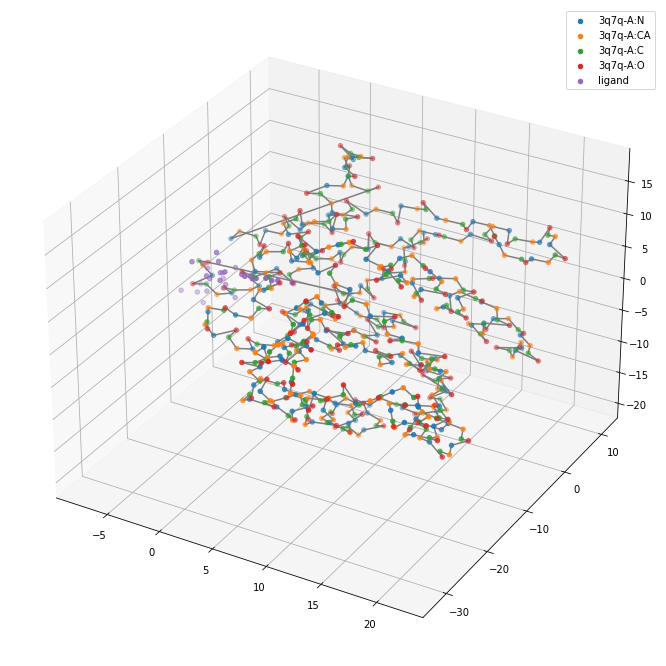

In [28]:
# Visualize 4 key atoms across amino acid residues in the pair of proteins
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for chain_id in records:
    ax = plot_backbone(records[chain_id], ax)
    
ax.scatter(ligand_pos[:, 0],
           ligand_pos[:, 1],
           ligand_pos[:, 2],
           label='ligand'
          );
    
ax.legend()